# Importing necessary libraries

In [1]:
import kagglehub
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, create_map, lit
from pyspark.sql.functions import length, trim
from itertools import chain
from pyspark import SparkContext
from pyspark.sql.functions import length
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt

# Importing dataset

In [2]:
# Download latest version
path = kagglehub.dataset_download("najzeko/steam-reviews-2021")

print("Path to dataset files:", path)

100%|██████████| 2.97G/2.97G [00:32<00:00, 98.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/najzeko/steam-reviews-2021/versions/1


In [3]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Steam Reviews Analysis") \
    .getOrCreate()

# Path to the dataset folder
dataset_path = "/root/.cache/kagglehub/datasets/najzeko/steam-reviews-2021/versions/1"

# Identify the CSV file
file_path = f"{dataset_path}/steam_reviews.csv"

# Load the data into a PySpark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True, multiLine=True, escape='"')

# Show a sample of the data
df.show(5)
# "schinese" is "simple chinese", "tchinese" is "traditional chinese"

+---+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|_c0|app_id|            app_name|review_id|language|                            review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author.steamid|author.num_games_owned|author.num_reviews|author.playtime_forever|author.playtime_last_two_weeks|author.playtime_at_review|author.last_played|
+---+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----------+-----

We tried translating every review to English but our machine could not process so much records. For this reason we decided to take a sample of the reviews (only those that are English). The number of those is around 9 million, which is considered to be Big Data.

In [4]:
df.filter(df.language == "english").count()

9635437

In [5]:
sample_df = df.filter(df.language == "english")

In [6]:
sample_df = sample_df.withColumn("review_length", length("review")) #create new column with the length of each review

##  **Exploratory Data Analysis**

In [7]:
#Rename the columns
from pyspark.sql.functions import col

# Rename each column manually
sample_df = sample_df.withColumnRenamed("author.steamid", "author_steamid") \
                     .withColumnRenamed("author.num_games_owned", "author_num_games_owned") \
                     .withColumnRenamed("author.num_reviews", "author_num_reviews") \
                     .withColumnRenamed("author.playtime_forever", "author_playtime_forever") \
                     .withColumnRenamed("author.playtime_last_two_weeks", "author_playtime_last_two_weeks") \
                     .withColumnRenamed("author.playtime_at_review", "author_playtime_at_review") \
                     .withColumnRenamed("author.last_played", "author_last_played")

# Check the updated column names
print(sample_df.columns)

['_c0', 'app_id', 'app_name', 'review_id', 'language', 'review', 'timestamp_created', 'timestamp_updated', 'recommended', 'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'author_steamid', 'author_num_games_owned', 'author_num_reviews', 'author_playtime_forever', 'author_playtime_last_two_weeks', 'author_playtime_at_review', 'author_last_played', 'review_length']


In [8]:
sample_df = sample_df.select("_c0","app_id","app_name","review_id","review","recommended","votes_helpful","steam_purchase","received_for_free","written_during_early_access","votes_helpful","author_steamid", "author_num_games_owned", "author_num_reviews", "author_playtime_forever", "author_playtime_at_review")

In [9]:
sample_df.show(5)

+---+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-------------+-----------------+----------------------+------------------+-----------------------+-------------------------+
|_c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|votes_helpful|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|
+---+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-------------+-----------------+----------------------+------------------+-----------------------+-------------------------+
|  3|292030|The Witcher 3: Wi...| 85184605|One of the best R...|       true|            0|          true|            false|                      false|            0|7656119

In [10]:
sample_df.select("author_playtime_at_review").describe().show()

+-------+-------------------------+
|summary|author_playtime_at_review|
+-------+-------------------------+
|  count|                  9623590|
|   mean|        9140.550526778468|
| stddev|       26469.392176559402|
|    min|                      1.0|
|    max|                3228103.0|
+-------+-------------------------+



In [11]:
sample_df.select("author_playtime_forever").describe().show()

+-------+-----------------------+
|summary|author_playtime_forever|
+-------+-----------------------+
|  count|                9635435|
|   mean|     16350.428221870627|
| stddev|     40881.450936788984|
|    min|                    0.0|
|    max|              3744943.0|
+-------+-----------------------+



In [12]:
# Create new columns for playtime categories
sample_df = sample_df.withColumn(
    "playtime_category",
    when(col("author_playtime_at_review") < 5000, "Low")
    .when((col("author_playtime_at_review") >= 5000) & (col("author_playtime_at_review") < 20000), "Medium")
    .otherwise("High")
)

sample_df = sample_df.withColumn(
    "playtime_forever_category",
    when(col("author_playtime_forever") < 5000, "Low")
    .when((col("author_playtime_forever") >= 5000) & (col("author_playtime_forever") < 20000), "Medium")
    .otherwise("High")
)

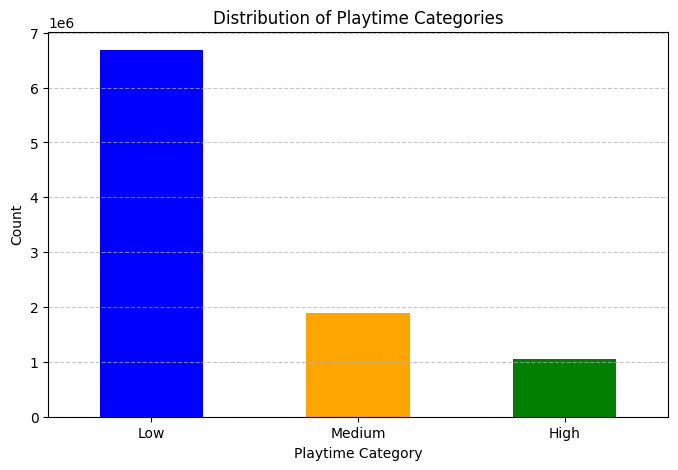

In [13]:
# Convert PySpark DataFrame to Pandas
pandas_df = sample_df.select("playtime_category").toPandas()

# Count occurrences of each category
category_counts = pandas_df["playtime_category"].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 5))
category_counts.plot(kind="bar", color=["blue", "orange", "green"])
plt.title("Distribution of Playtime Categories")
plt.xlabel("Playtime Category")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

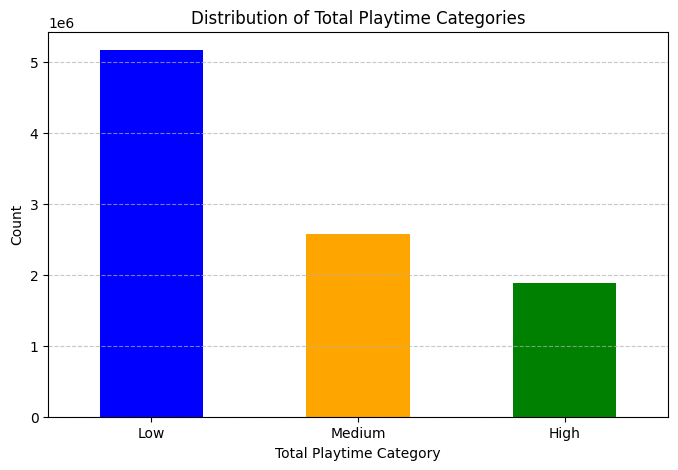

In [14]:
# Convert PySpark DataFrame to Pandas
pandas_df = sample_df.select("playtime_forever_category").toPandas()

# Count occurrences of each category
category_counts_forever = pandas_df["playtime_forever_category"].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 5))
category_counts_forever.plot(kind="bar", color=["blue", "orange", "green"])
plt.title("Distribution of Total Playtime Categories")
plt.xlabel("Total Playtime Category")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

In [15]:
sample_df.select("app_name").distinct().show()

+--------------------+
|            app_name|
+--------------------+
|    Human: Fall Flat|
|DRAGON BALL FighterZ|
|The Elder Scrolls...|
|      Umbrella Corps|
|    Wallpaper Engine|
|          Nova Drift|
|           Detention|
|      SOULCALIBUR VI|
|The Witcher 3: Wi...|
|         GOD EATER 3|
|The Legend of Her...|
|     Thief Simulator|
|Ori and the Will ...|
|Danganronpa 2: Go...|
|       STEINS;GATE 0|
|        Just Cause 3|
|      NieR:Automata™|
|                 SOS|
| BattleBlock Theater|
|        For The King|
+--------------------+
only showing top 20 rows



In [16]:
sample_df.groupBy("app_name").count().sort(col("count").desc()).show()  #sort in desc order to find apps with many reviews

+--------------------+------+
|            app_name| count|
+--------------------+------+
|    Human: Fall Flat| 24684|
|DRAGON BALL FighterZ| 16864|
|The Elder Scrolls...|160233|
|      Umbrella Corps|  1055|
|    Wallpaper Engine| 80986|
|          Nova Drift|  2499|
|           Detention|  2046|
|      SOULCALIBUR VI|  5021|
|The Witcher 3: Wi...|151460|
|         GOD EATER 3|  1842|
|The Legend of Her...|  1160|
|     Thief Simulator|  3592|
|Ori and the Will ...| 14417|
|Danganronpa 2: Go...|  7347|
|       STEINS;GATE 0|   775|
|        Just Cause 3| 36850|
|      NieR:Automata™| 34564|
|                 SOS|  1891|
| BattleBlock Theater| 24711|
|        For The King|  6895|
+--------------------+------+
only showing top 20 rows



<ipython-input-17-006a55b364aa>:10: UserWarning: Glyph 65290 (\N{FULLWIDTH ASTERISK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-006a55b364aa>:10: UserWarning: Glyph 40857 (\N{CJK UNIFIED IDEOGRAPH-9F99}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-006a55b364aa>:10: UserWarning: Glyph 23830 (\N{CJK UNIFIED IDEOGRAPH-5D16}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-006a55b364aa>:10: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-006a55b364aa>:10: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-006a55b364aa>:10: UserWarning: Glyph 32676 (\N{CJK UNIFIED IDEOGRAPH-7FA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-006a55b364aa>:10: UserWarning: Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from font(s)

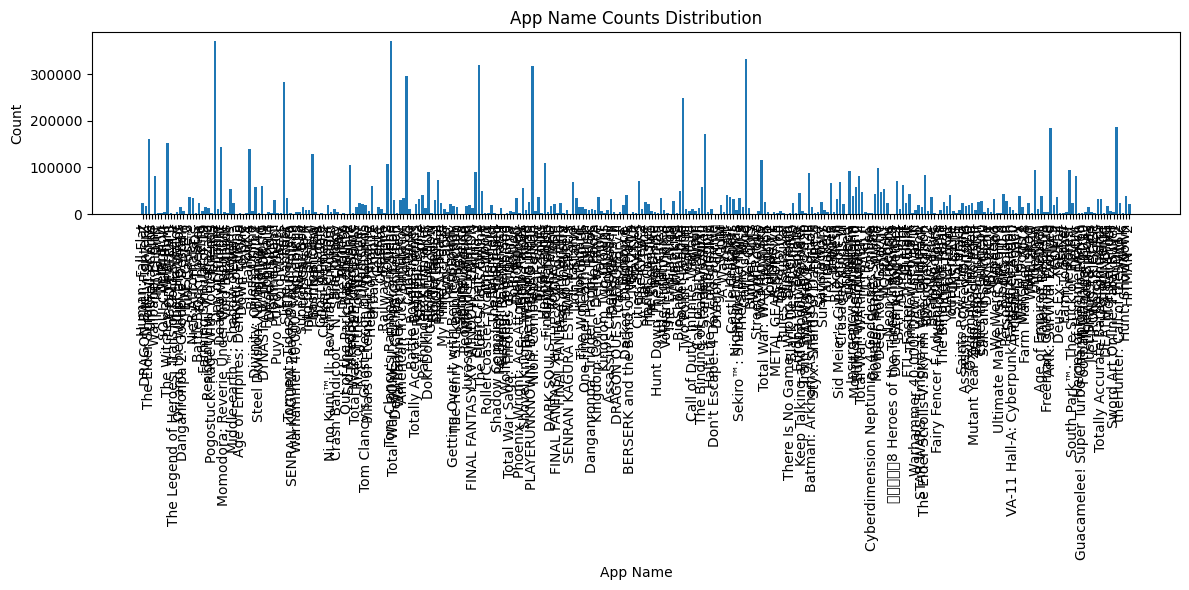

In [17]:
#The following plot is not very interpretable, due to the large number of app names

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = sample_df.groupBy("app_name").count().toPandas()

plt.figure(figsize=(12, 6))
plt.bar(pandas_df['app_name'].astype(str), pandas_df['count'])
plt.xticks(rotation=90)
plt.xlabel("App Name")
plt.ylabel("Count")
plt.title("App Name Counts Distribution")
plt.tight_layout()
plt.show()


In [18]:
sample_df.groupBy("steam_purchase").count().show()

+--------------+-------+
|steam_purchase|  count|
+--------------+-------+
|          true|7443988|
|         false|2191449|
+--------------+-------+



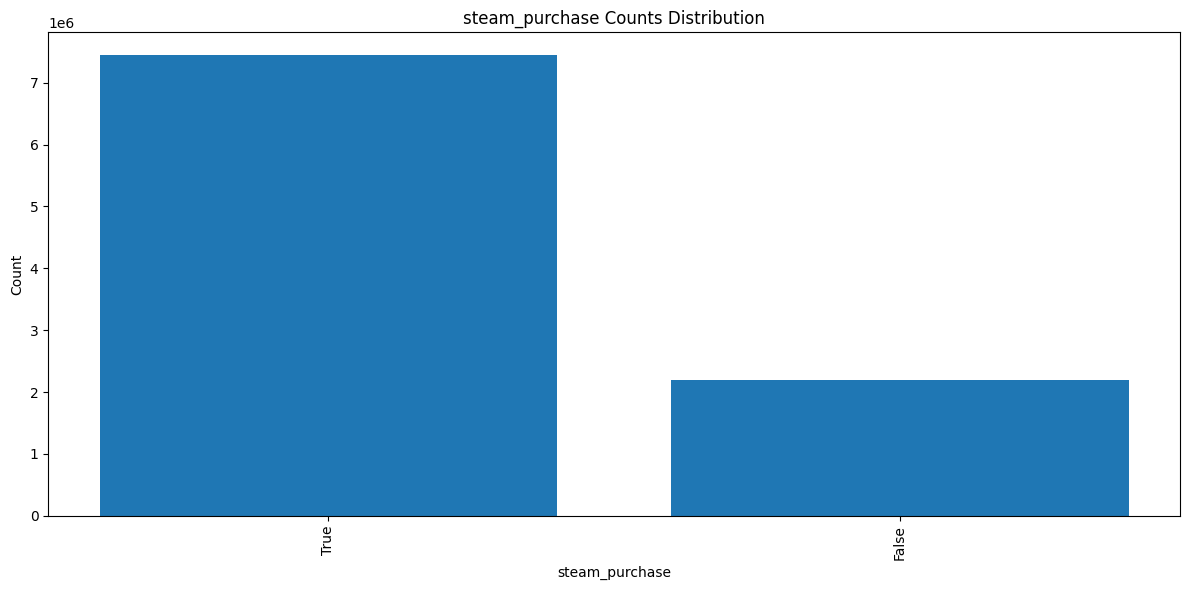

In [19]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = sample_df.groupBy("steam_purchase").count().toPandas()

plt.figure(figsize=(12, 6))
plt.bar(pandas_df['steam_purchase'].astype(str), pandas_df['count'])
plt.xticks(rotation=90)
plt.xlabel("steam_purchase")
plt.ylabel("Count")
plt.title("steam_purchase Counts Distribution")
plt.tight_layout()
plt.show()


In [20]:
sample_df.groupBy("received_for_free").count().show()

+-----------------+-------+
|received_for_free|  count|
+-----------------+-------+
|             true| 279384|
|            false|9356053|
+-----------------+-------+



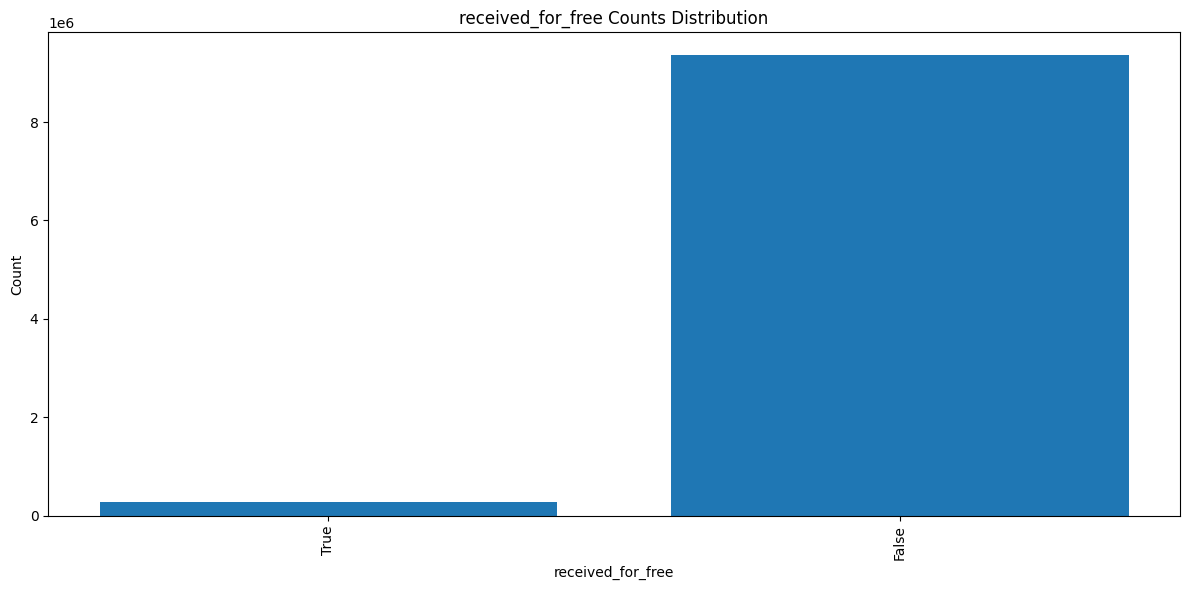

In [21]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = sample_df.groupBy("received_for_free").count().toPandas()

plt.figure(figsize=(12, 6))
plt.bar(pandas_df['received_for_free'].astype(str), pandas_df['count'])
plt.xticks(rotation=90)
plt.xlabel("received_for_free")
plt.ylabel("Count")
plt.title("received_for_free Counts Distribution")
plt.tight_layout()
plt.show()


In [22]:
sample_df.groupBy("written_during_early_access").count().show()

+---------------------------+-------+
|written_during_early_access|  count|
+---------------------------+-------+
|                       true| 959460|
|                      false|8675977|
+---------------------------+-------+



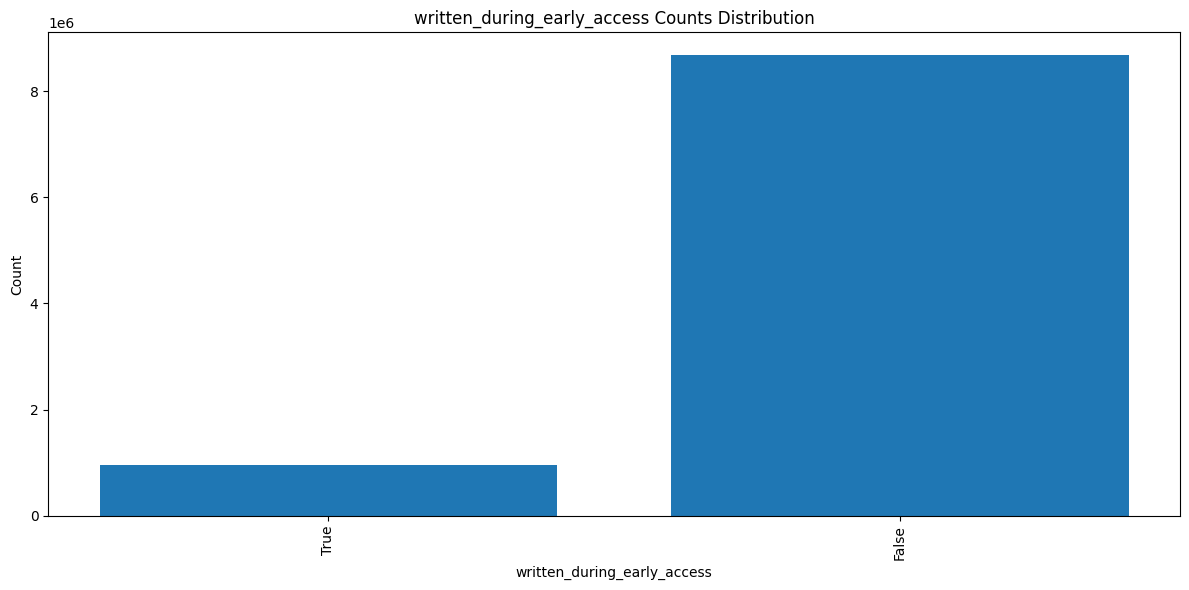

In [23]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = sample_df.groupBy("written_during_early_access").count().toPandas()

plt.figure(figsize=(12, 6))
plt.bar(pandas_df['written_during_early_access'].astype(str), pandas_df['count'])
plt.xticks(rotation=90)
plt.xlabel("written_during_early_access")
plt.ylabel("Count")
plt.title("written_during_early_access Counts Distribution")
plt.tight_layout()
plt.show()


In [26]:
sample_df.groupBy("author_steamid").count().sort(col("count").desc()).show()   #sort in descending order to see the most frequent reviewers!

+-----------------+-----+
|   author_steamid|count|
+-----------------+-----+
|76561198062813911|  149|
|76561198315585536|  132|
|76561198045381877|  103|
|76561198064946151|  100|
|76561197969749884|   88|
|76561197997059777|   81|
|76561197990947284|   80|
|76561198048086581|   79|
|76561198011965365|   79|
|76561197999920602|   79|
|76561198166188807|   79|
|76561197970761123|   78|
|76561198038757354|   77|
|76561198112669681|   76|
|76561198094803808|   75|
|76561198057221241|   73|
|76561197986406741|   72|
|76561197999935168|   72|
|76561198266073876|   71|
|76561198082610824|   70|
+-----------------+-----+
only showing top 20 rows



In [30]:
# Convert 'recommended' column to integers for mean calculation
sample_df = sample_df.withColumn('recommended', df['recommended'].cast('int'))

# Pivot table calculation with mean aggregation
pivot_table = sample_df.groupBy('received_for_free').agg(
    {'recommended': 'avg'}
).withColumnRenamed('avg(recommended)', 'Mean Recommended')

# Show results
pivot_table.show()

+-----------------+------------------+
|received_for_free|  Mean Recommended|
+-----------------+------------------+
|             true|0.8892921570311829|
|            false|0.8909729348476328|
+-----------------+------------------+



# bivariate analysis

In [ ]:
sample_df.groupBy("received_for_free", "recommended").count().show()

In [ ]:
sample_df.groupBy("app_name", "steam_purchase").count().show()

In [ ]:
sample_df.groupBy("app_name", "recommended").count().show()

In [ ]:
sample_df.groupBy("app_name", "received_for_free").count().show()

In [ ]:
sample_df.groupBy("app_name", "written_during_early_access").count().show()

In [ ]:
sample_df.groupBy("steam_purchase", "reccomended").count().show()

In [ ]:
sample_df.groupBy("author_steamid", "written_during_early_access").count().show()

In [ ]:
sample_df.groupBy("playtime_forever_category", "recommended").count().show()

In [ ]:
sample_df.groupBy("playtime_category", "recommended").count().show()

In [ ]:
sample_df.groupBy("written_during_early_access", "recommended").count().show()

In [ ]:
sample_df.groupBy("author_num_games_owned", "recommended").count().show()

+-----------------+-------------+------------------+----------------------+
|received_for_free|Total Reviews|Recommended (True)|Proportion Recommended|
+-----------------+-------------+------------------+----------------------+
|             true|       279384|            248454|    0.8892921570311829|
|            false|      9356053|           8335990|    0.8909729348476328|
+-----------------+-------------+------------------+----------------------+

